In [1]:
import os
from typing import Generator

import anndata as ad
import matplotlib.pyplot as plt

In [2]:
RAW_DATA_DIR = "../data/raw"  # where .counts.tsv files are stored
H5AD_DIR = "../data/h5ad"  # where .h5ad files will be stored

# metadata column keys in adata.obs
SAMPLE_NAME_KEY = "sample_name"  # e.g. MIA2ME18
SAMPLE_TYPE_KEY = "sample_type"  # MIA (maternal immune activation) or PBS (control)
SEX_KEY = "sex"  # M or F
TIMEPOINT_KEY = "timepoint"  # E14 or E18

In [3]:
def get_count_files(
    data_path: str,
    target_extension: str = ".counts.tsv",
) -> Generator[str, None, None]:
    """Get all files that end in .counts.tsv."""
    for f in os.listdir(data_path):
        if f.endswith(target_extension):
            yield os.path.join(data_path, f)


def sparsify_adata(adata: ad.AnnData) -> ad.AnnData:
    """Convert the dense matrix in an AnnData object to a sparse matrix.
    
    Helps with reducing the file size of the .h5ad file.
    """
    from scipy.sparse import csr_matrix

    adata.X = csr_matrix(adata.X)
    return adata


def cast_and_unique_indexes(adata: ad.AnnData) -> ad.AnnData:
    """Cast the indexes of an AnnData object to strings and make them unique."""
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    return adata


def add_obs_metadata(adata: ad.AnnData, sample_name: str) -> ad.AnnData:
    """Add metadata to the observations of an AnnData object."""
    adata.obs[SAMPLE_NAME_KEY] = sample_name
    adata.obs[SEX_KEY] = sample_name[-4:-3]  # e.g. MIA2ME18 -> M
    adata.obs[TIMEPOINT_KEY] = sample_name[-3:]  # e.g. MIA2ME18 -> E18
    adata.obs[SAMPLE_TYPE_KEY] = sample_name[:3]  # e.g. MIA2ME18 -> MIA
    adata.obs.index = sample_name + "_" + adata.obs.index
    return adata


def save_adata(adata: ad.AnnData, sample_name: str, adata_dir: str) -> tuple[ad.AnnData, str]:
    """Save an AnnData object as a .h5ad file.
    
    Creates the directory if it doesn't exist.
    """
    from pathlib import Path
    
    adata_path = os.path.join(adata_dir, f"{sample_name}.h5ad")
    Path(adata_path).parent.mkdir(parents=True, exist_ok=True)
    adata.write(adata_path, compression="gzip")
    return adata, adata_path


def convert_tsv_to_h5ad(tsv_path: str, adata_dir: str) -> ad.AnnData:
    """Convert a .tsv file to an AnnData object and save it as a .h5ad file."""
    adata = ad.read_csv(tsv_path, delimiter="\t")
    adata = sparsify_adata(adata)
    adata = cast_and_unique_indexes(adata)

    # e.g. ../GSM4456522_MIA2ME18.counts.tsv -> MIA2ME18
    sample_name = tsv_path.split("/")[-1].split(".")[0].split("_")[1]
    adata = add_obs_metadata(adata, sample_name)

    adata, _ = save_adata(adata, sample_name, adata_dir)
    return adata


def convert_and_save_adatas(raw_data_dir: str, adata_dir: str) -> list[ad.AnnData]:
    """Convert all .counts.tsv files to .h5ad files and return a list of AnnData objects."""
    return [convert_tsv_to_h5ad(f, adata_dir) for f in get_count_files(raw_data_dir)]


def concat_and_save_adata(adatas: list[ad.AnnData], adata_dir: str) -> ad.AnnData:
    """Concatenate a list of AnnData objects and save it as a .h5ad file."""
    adata = ad.concat(adatas, join="inner")  # inner since genes are the same across samples
    assert adata.n_obs == sum(adata.n_obs for adata in adatas)
    assert adata.n_vars == max(adata.n_vars for adata in adatas)

    adata, _ = save_adata(adata, "all_samples", adata_dir)
    return adata

In [4]:
# this will take a couple of minutes
adatas = convert_and_save_adatas(RAW_DATA_DIR, H5AD_DIR)

In [5]:
# this takes around a minute
adata = concat_and_save_adata(adatas, H5AD_DIR)

In [11]:
print("number of cells:", adata.n_obs)
print("number of genes:", adata.n_vars)

number of cells: 622156
number of genes: 25289


In [8]:
def plot_n_obs_by_obs_key(adata: ad.AnnData, obs_key: str) -> None:
    """Plot the number of observations by an obs key."""
    adata.obs[obs_key].value_counts().plot(kind="bar")

    plt.title(f"number of observations by {obs_key}")
    plt.ylabel("number of observations")
    plt.show()

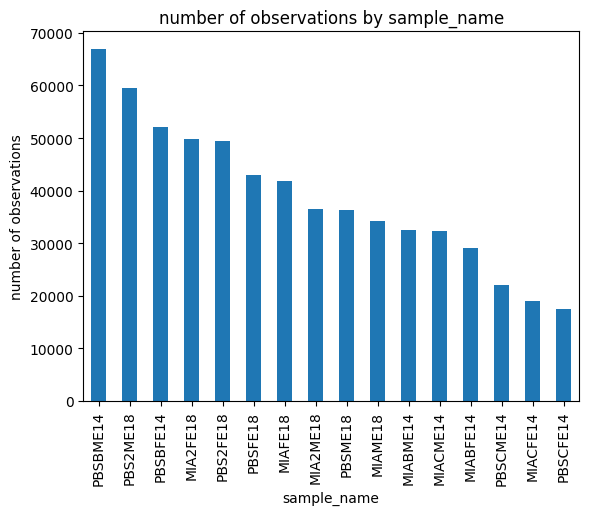

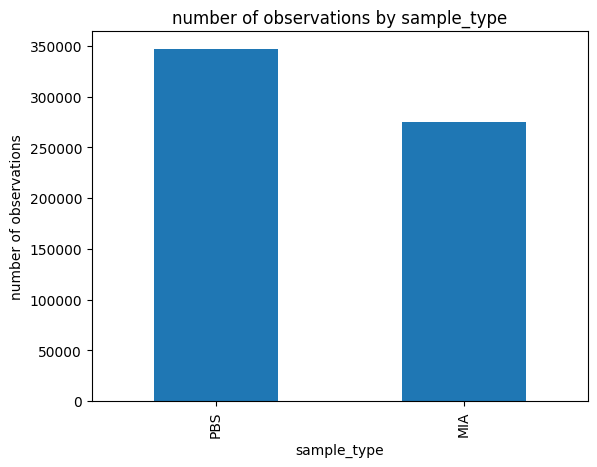

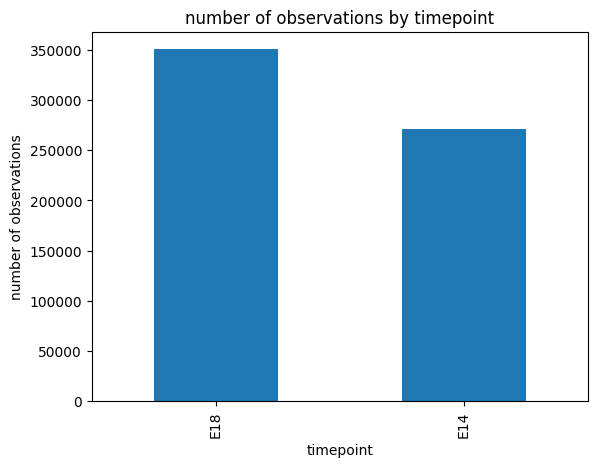

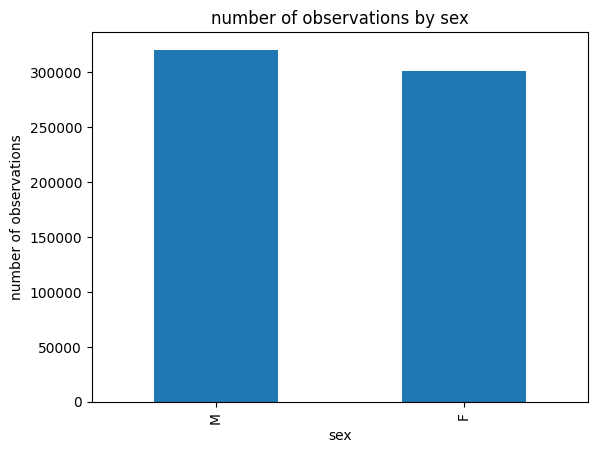

In [9]:
for key in (SAMPLE_NAME_KEY, SAMPLE_TYPE_KEY, TIMEPOINT_KEY, SEX_KEY):
    plot_n_obs_by_obs_key(adata, key)